In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [110]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [111]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [112]:
injuryData

,ID,Date,Team,Acquired,Relinquished,Notes
0,0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL
1,1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle
2,2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list
3,3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...
4,4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty
...,...,...,...,...,...,...
37662,37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL
37663,37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL
37664,37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL
37665,37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL


### We want to separate the dataset by decade to get a good idea of the total number of injuries that have occured year by year

In [113]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)

In [114]:
injuryData

,ID,Date,Team,Acquired,Relinquished,Notes,Year
0,0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL,1951
1,1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle,1952
2,2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list,1956
3,3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...,1959
4,4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty,1961
...,...,...,...,...,...,...,...
37662,37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL,2023
37663,37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL,2023
37664,37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL,2023
37665,37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL,2023


### Now let's calculate the total sum of injuries for each Year

In [115]:
data = {}
for year, group in injuryData.groupby('Year'):
    injuries = group.shape[0]
    data[year] = injuries 
    print(f"Year: {year} Injuries: {injuries}")
    print("---------------------------------------------")


Year: 1951 Injuries: 1
---------------------------------------------
Year: 1952 Injuries: 1
---------------------------------------------
Year: 1956 Injuries: 1
---------------------------------------------
Year: 1959 Injuries: 1
---------------------------------------------
Year: 1961 Injuries: 1
---------------------------------------------
Year: 1962 Injuries: 5
---------------------------------------------
Year: 1965 Injuries: 1
---------------------------------------------
Year: 1969 Injuries: 3
---------------------------------------------
Year: 1970 Injuries: 1
---------------------------------------------
Year: 1971 Injuries: 3
---------------------------------------------
Year: 1972 Injuries: 6
---------------------------------------------
Year: 1973 Injuries: 7
---------------------------------------------
Year: 1974 Injuries: 14
---------------------------------------------
Year: 1975 Injuries: 9
---------------------------------------------
Year: 1976 Injuries: 18
---------

Text(0.5, 1.0, 'Number of Injuries Year by Year')

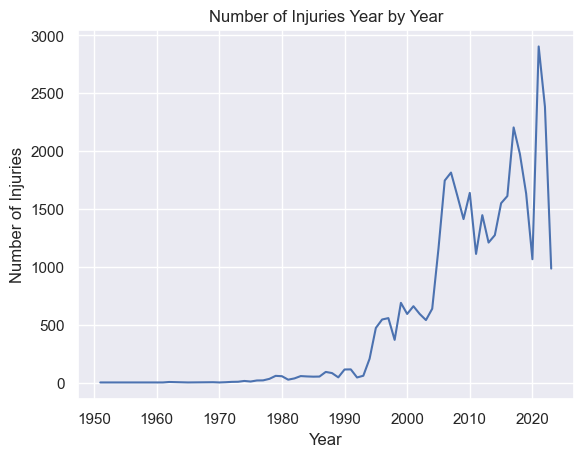

In [116]:
sns.set(style="darkgrid")
sns.lineplot(x=data.keys(), y=data.values(), data=data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')

### We have to encode the data for the "Team" column

In [117]:
# Encoding each unique team instance
label_encoder = LabelEncoder()
encoded_column = label_encoder.fit_transform(injuryData['Team'])
injuryData['Team'] = encoded_column
unique_values = injuryData['Team'].nunique()
print("Number of unique teams:", unique_values)

Number of unique teams: 44


### Let's now remove all rows where the players have been reliquished back from the IL 


In [118]:
# Removing the relinquished column removes all duplicates 
filtered_data = injuryData[injuryData['Relinquished'].isna()]

In [121]:
print(filtered_data)

          ID       Date  Team            Acquired Relinquished   
5          5 1962-03-24    20        Elgin Baylor          NaN  \
6          6 1962-03-31    20        Elgin Baylor          NaN   
8          8 1962-11-06    43          Al Ferrari          NaN   
12        12 1969-10-28     4         Bob Greacen          NaN   
16        16 1971-10-30    35            Doug Moe          NaN   
...      ...        ...   ...                 ...          ...   
37662  37662 2023-04-16    11       Marcus Morris          NaN   
37663  37663 2023-04-16    13       Dillon Brooks          NaN   
37664  37664 2023-04-16    13           Ja Morant          NaN   
37665  37665 2023-04-16    13   Jaren Jackson Jr.          NaN   
37666  37666 2023-04-16    13        Santi Aldama          NaN   

                                              Notes  Year  
5        player given 2-day pass from military duty  1962  
6      player given weekend pass from military duty  1962  
8                      acti